<a href="https://colab.research.google.com/github/pvpogorelova/metrics_25_26/blob/main/sem_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Семинар 9: Мультиколлинеарность.**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import warnings

**Строгая мультиколлинеарность.**

In [ ]:
# Сгенерируем данные со строгой мультиколлинеарностью

np.random.seed(42)
n = 100
x1 = np.random.normal(0, 1, n)
x2 = 2 * x1  # строгая мультиколлинеарность
x3 = np.random.normal(0, 1, n)

# Добавляем шум
eps = np.random.normal(0, 0.1, n)
y = 2*x1 + 0.5*x2 + 3*x3 + eps

# Создаем DataFrame
df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y': y})

print("Первые 5 строк данных:")
print(df.head())
print(f"\nКорреляция между x1 и x2: {df['x1'].corr(df['x2']):.6f}")

# Определитель матрицы корреляций
corr_matrix = df[['x1', 'x2', 'x3']].corr()
det = np.linalg.det(corr_matrix)
print(f"\nОпределитель матрицы корреляций: {det:.10f}")

Первые 5 строк данных:
         x1        x2        x3         y
0  0.496714  0.993428 -1.415371 -2.720191
1 -0.138264 -0.276529 -0.420645 -1.620650
2  0.647689  1.295377 -0.342715  1.023227
3  1.523030  3.046060 -0.802277  2.267638
4 -0.234153 -0.468307 -0.161286 -1.324084

Корреляция между x1 и x2: 1.000000

Определитель матрицы корреляций: 0.0000000000


Оценим линейную регрессию со строгой мультиколлинеарностью в statsmodels.

In [ ]:
# Добавляем константу
model_smf = smf.ols('y ~ x1 + x2 + x3', data=df)  # ols строчными
results_smf = model_smf.fit()
print(results_smf.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.811e+04
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          4.72e-150
Time:                        11:15:54   Log-Likelihood:                 82.636
No. Observations:                 100   AIC:                            -159.3
Df Residuals:                      97   BIC:                            -151.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.011      0.819      0.4

Statsmodels выдаёт предупреждение о возможной строгой мультиколлинеарности.

Теперь давайте попробуем оценить ту же самую модель в sklearn.

In [ ]:
X_sk = df[['x1', 'x2', 'x3']]

model_sk = LinearRegression()
print(model_sk.fit(X_sk, df['y']))

print("Коэффициенты sklearn:")
print(f"Intercept: {model_sk.intercept_:.6f}")
for i, col in enumerate(['x1', 'x2', 'x3']):
    print(f"{col}: {model_sk.coef_[i]:.6f}")

print(f"\nR² score: {model_sk.score(X_sk, df['y']):.6f}")

LinearRegression()
Коэффициенты sklearn:
Intercept: 0.008865
x1: 0.604522
x2: 1.209044
x3: 2.998772

R² score: 0.999166


Sklearn не выдает никаких предупреждений о наличии строгой мультиколлинеарности.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# **Квазимультиколлинеарность.**

Теперь изучим, что происходит с оценками, когда в данных нет строгой мультиколлинеарности, однако, наблюдается высокая корреляция между регрессорами (такую ситуацию обычно и имеют ввиду, когда говорят о проблеме мультиколлинеарности в данных).

In [ ]:
# Функция для генерации данных с нестрогой мультиколлинеарностью
def generate_collinear_data(n_samples, corr_strength, n_features=3, eps_std=1.0):

    np.random.seed(42)

    # Генерируем объясняющие переменные
    X = np.random.normal(0, 1, (n_samples, n_features))

    # Создаем коррелированные признаки
    X_correlated = X.copy()
    for i in range(1, n_features):
        X_correlated[:, i] = (corr_strength * X[:, 0] +
                             np.sqrt(1 - corr_strength**2) * X[:, i])

    # Истинные коэффициенты
    true_beta = np.array([2.0, -1.5, 1.0])[:n_features]

    # Генерируем зависимую переменную
    y = X_correlated @ true_beta + np.random.normal(0, eps_std, n_samples)

    return X_correlated, y, true_beta

# Функция для расчета VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = [f"X{i+1}" for i in range(X.shape[1])]
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data

**Изучим последствия мультиколлинеарности разной степени выраженности на малой выборке.**

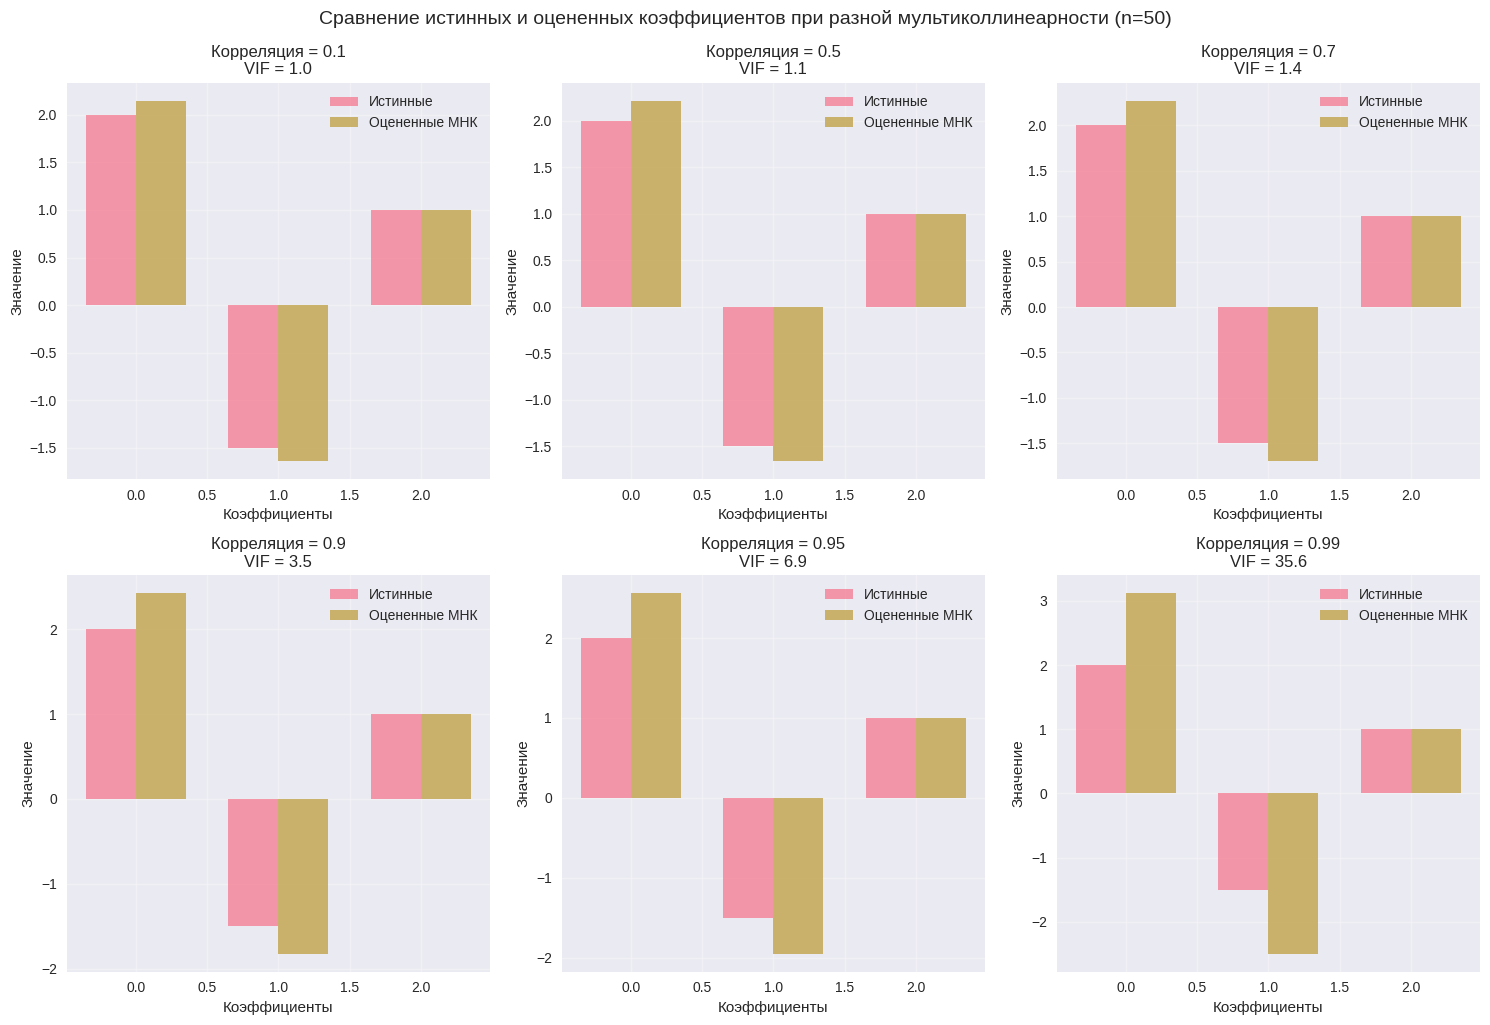


Результаты для малой выборки (n=50):
   correlation  avg_vif  avg_coef_error    mse
0         0.10    1.023           0.097  0.749
1         0.50    1.084           0.126  0.749
2         0.70    1.402           0.156  0.749
3         0.90    3.481           0.249  0.749
4         0.95    6.880           0.338  0.749
5         0.99   35.597           0.706  0.749


In [ ]:
correlations = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99] # зададим корреляции
results_small = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, corr in enumerate(correlations):
    X, y, true_beta = generate_collinear_data(50, corr, n_features=3)

    # Оценим модель линейной регрессии
    model = LinearRegression()
    model.fit(X, y)

    # Получаем предсказания и оценки
    y_hat = model.predict(X)
    mse = mean_squared_error(y, y_hat)

    # Сравниваем с истинными коэффициентами
    coef_errors = np.abs(model.coef_ - true_beta)

    # Рассчитываем VIF
    vif_df = calculate_vif(X)
    avg_vif = vif_df['VIF'].mean()

    results_small.append({
        'correlation': corr,
        'mse': mse,
        'avg_coef_error': np.mean(coef_errors),
        'avg_vif': avg_vif,
        'estimated_coefs': model.coef_,
        'true_coefs': true_beta
    })

    # Визуализация коэффициентов
    x_pos = np.arange(len(true_beta))
    width = 0.35

    axes[idx].bar(x_pos - width/2, true_beta, width, label='Истинные', alpha=0.7)
    axes[idx].bar(x_pos + width/2, model.coef_, width, label='Оцененные МНК', alpha=0.7)
    axes[idx].set_title(f'Корреляция = {corr}\nVIF = {avg_vif:.1f}')
    axes[idx].set_xlabel('Коэффициенты')
    axes[idx].set_ylabel('Значение')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Сравнение истинных и оцененных коэффициентов при разной мультиколлинеарности (n=50)',
             y=1.02, fontsize=14)
plt.show()

# Вывод результатов в таблицу
results_df_small = pd.DataFrame(results_small)
print("\nРезультаты для малой выборки (n=50):")
print(results_df_small[['correlation', 'avg_vif', 'avg_coef_error', 'mse']].round(3))

**Как влияет размер выборки на точность оценок при разной степени выраженности мультиколлинеарности?**

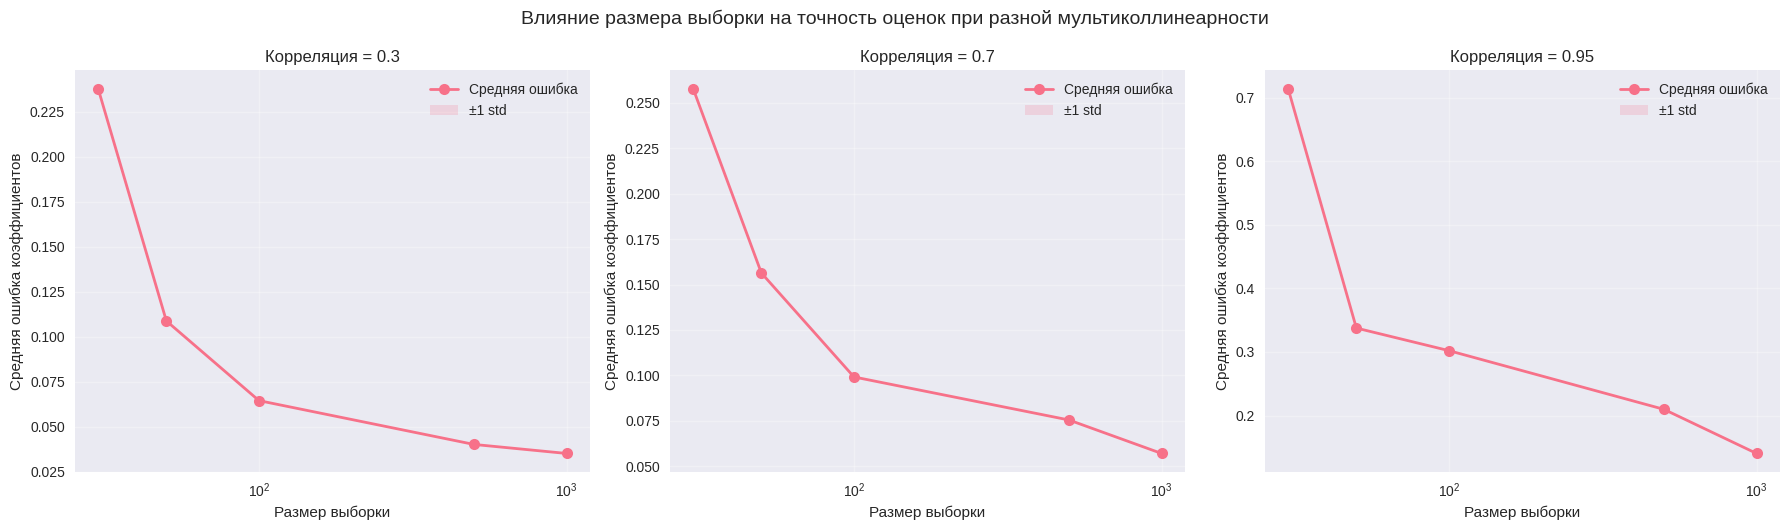

In [ ]:
 ==sample_sizes = [30, 50, 100, 500, 1000] # зададим объем выборки
correlation_levels = [0.3, 0.7, 0.95] # зададим корреляции

results_comparison = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, corr in enumerate(correlation_levels):
    coef_errors_small = []
    coef_errors_large = []

    for n in sample_sizes:
        # Многократное симулирование для оценки стабильности
        n_simulations = 100
        errors = []

        for _ in range(n_simulations):
            X, y, true_beta = generate_collinear_data(n, corr, n_features=3)
            model = LinearRegression()
            model.fit(X, y)
            error = np.mean(np.abs(model.coef_ - true_beta))
            errors.append(error)

        results_comparison.append({
            'sample_size': n,
            'correlation': corr,
            'mean_coef_error': np.mean(errors),
            'std_coef_error': np.std(errors)
        })

    # Фильтруем результаты для текущей корреляции
    current_results = [r for r in results_comparison if r['correlation'] == corr]
    sizes = [r['sample_size'] for r in current_results]
    mean_errors = [r['mean_coef_error'] for r in current_results]
    std_errors = [r['std_coef_error'] for r in current_results]

    axes[idx].plot(sizes, mean_errors, 'o-', linewidth=2, markersize=8,
                   label='Средняя ошибка')
    axes[idx].fill_between(sizes,
                          np.array(mean_errors) - np.array(std_errors),
                          np.array(mean_errors) + np.array(std_errors),
                          alpha=0.2, label='±1 std')
    axes[idx].set_xlabel('Размер выборки')
    axes[idx].set_ylabel('Средняя ошибка коэффициентов')
    axes[idx].set_title(f'Корреляция = {corr}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xscale('log')

plt.tight_layout()
plt.suptitle('Влияние размера выборки на точность оценок при разной мультиколлинеарности',
             y=1.05, fontsize=14)
plt.show()

Таким образом, последствия мультиколлинеарности на большом объеме данных сходят на нет. Большое количество информации приводит к снижению дисперсии оценок коэффициентов. Модель оценивается корректно, можно делать выводы.

# Продемонстрируем неустойчивость МНК-оценок при мультиколлинеарности.

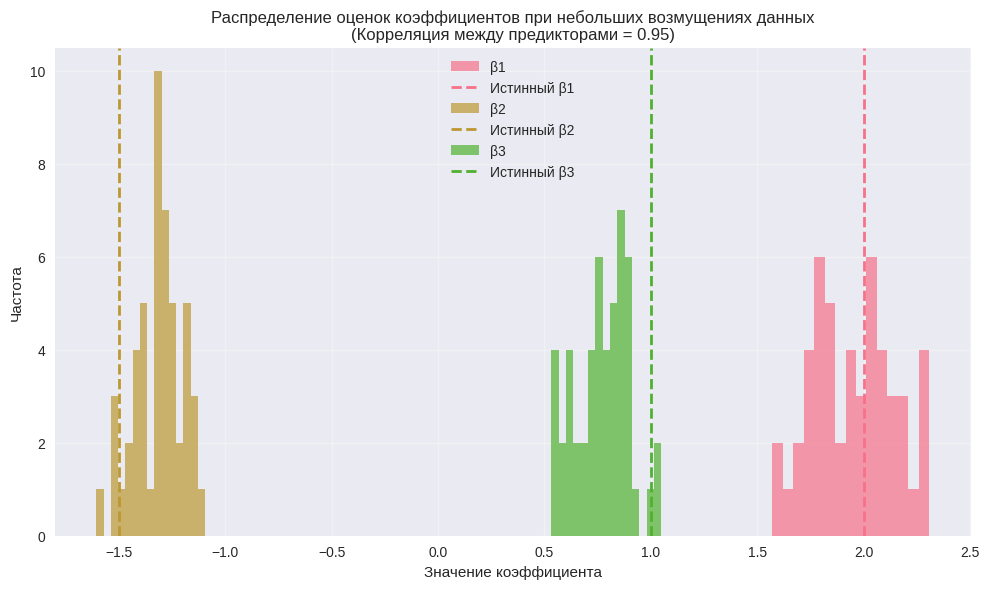

Стандартные отклонения оценок коэффициентов:
β1: 0.193 (истинное значение: 2.0)
β2: 0.110 (истинное значение: -1.5)
β3: 0.127 (истинное значение: 1.0)

Вывод: При сильной мультиколлинеарности даже небольшие возмущения в данных приводят к значительным изменениям оценок коэффициентов, что демонстрирует
их неустойчивость и низкую надежность.


In [ ]:
# Генерируем исходные данные

np.random.seed(42)
X_base, y_base, true_beta = generate_collinear_data(100, 0.95, n_features=3)

# Симулируем небольшие возмущения в данных
n_perturbations = 50
coef_variations = []

plt.figure(figsize=(10, 6))

for i in range(n_perturbations):
    # добавляем небольшой шум к данным
    noise_scale = 0.1
    X_perturbed = X_base + np.random.normal(0, noise_scale, X_base.shape)

    # Оценим модель на данных с шумом
    model = LinearRegression()
    model.fit(X_perturbed, y_base)

    coef_variations.append(model.coef_)

coef_variations = np.array(coef_variations)

# Построим гистограммы распределения оценок каждого из коэффициентов
for i in range(3):
    plt.hist(coef_variations[:, i], alpha=0.7, label=f'β{i+1}', bins=15)
    plt.axvline(true_beta[i], color=f'C{i}', linestyle='--', linewidth=2,
                label=f'Истинный β{i+1}')

plt.xlabel('Значение коэффициента')
plt.ylabel('Частота')
plt.title('Распределение оценок коэффициентов при небольших возмущениях данных\n(Корреляция между предикторами = 0.95)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Стандартные отклонения оценок коэффициентов:")
for i in range(3):
    print(f"β{i+1}: {np.std(coef_variations[:, i]):.3f} (истинное значение: {true_beta[i]:.1f})")

print("\nВывод: При сильной мультиколлинеарности даже небольшие возмущения в данных приводят к значительным изменениям оценок коэффициентов, что демонстрирует")
print("их неустойчивость и низкую надежность.")